In [39]:




import pandas as pd
from pandas import Series,DataFrame

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import csv
import gzip
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import cross_validation
from sklearn import ensemble, preprocessing


In [40]:
# get crimes & test csv files as a DataFrame
crimes_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
Sample_submission = pd.read_csv('sampleSubmission.csv')

# preview the data
crimes_df.tail(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.394926,37.738212


In [41]:
# preview the data
test_df.head(2)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432


In [42]:
crimes_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 67.0+ MB
----------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 884262 entries, 0 to 884261
Data columns (total 7 columns):
Id            884262 non-null int64
Dates         884262 non-null object
DayOfWeek     884262 non-null object
PdDistrict    884262 non-null object
Address       884262 non-null object
X             884262 non-null float64
Y             884262 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.0+ MB


In [43]:
#Split the date colum
def create_year(x):
    return x.split('-')[0]
    
def create_month(x):
    return x.split('-')[1]
    
def create_daytemp(x):
    return x.split('-')[2]
    
def create_time(x):
    return x.split(' ')[1]


In [44]:
#for training data
crimes_df["Year"] = crimes_df["Dates"].apply(create_year)
crimes_df["Month"] = crimes_df["Dates"].apply(create_month)
crimes_df["Day"] = crimes_df["Dates"].apply(create_daytemp)
crimes_df["Time"] = crimes_df["Day"].apply(create_time)

#for testing data
test_df["Year"] = test_df["Dates"].apply(create_year)
test_df["Month"] = test_df["Dates"].apply(create_month)
test_df["Day"] = test_df["Dates"].apply(create_daytemp)
test_df["Time"] = test_df["Day"].apply(create_time)

In [45]:
crimes_df.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Time
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,05,13 23:53:00,23:53:00
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,05,13 23:53:00,23:53:00


In [46]:
def create_day(x):
    return x.split(' ')[0]

In [47]:
crimes_df["Day"] = crimes_df["Day"].apply(create_day)
test_df["Day"] = test_df["Day"].apply(create_day)

In [48]:
def create_hours(x):
    return x.split(':')[0]

In [49]:
crimes_df["Hours"] = crimes_df["Time"].apply(create_hours)
test_df["Hours"] = test_df["Time"].apply(create_hours)

In [50]:
crimes_df.head(1)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Time,Hours
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,05,13,23:53:00,23


In [51]:
colr = (
        'Set2', 'Paired', 'colorblind', 'husl',
        'Set1', 'coolwarm', 'RdYlGn', 'spectral'
    )

In [52]:
clr = sns.color_palette(np.random.choice(colr), len(crimes_df))

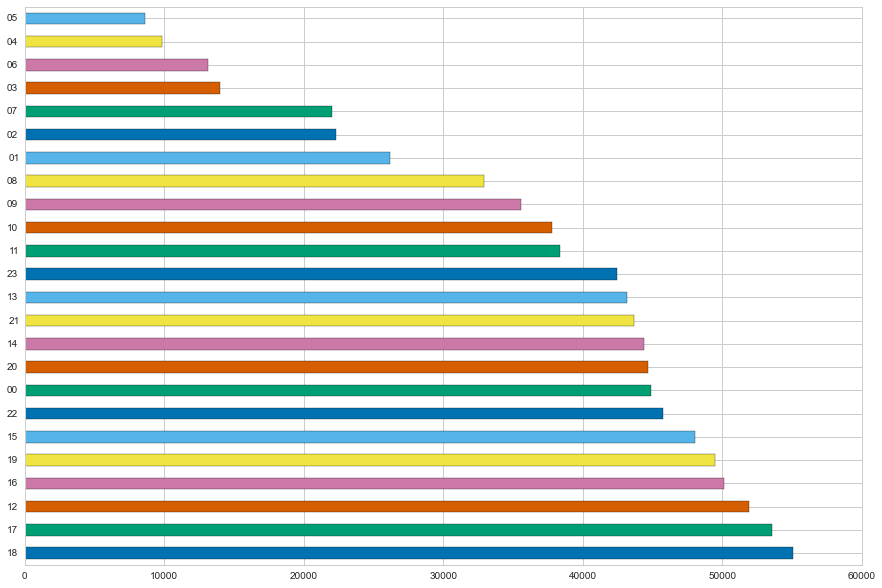

In [53]:
crimes_df.Hours.value_counts().plot(kind='barh', figsize=(15,10), color=clr)

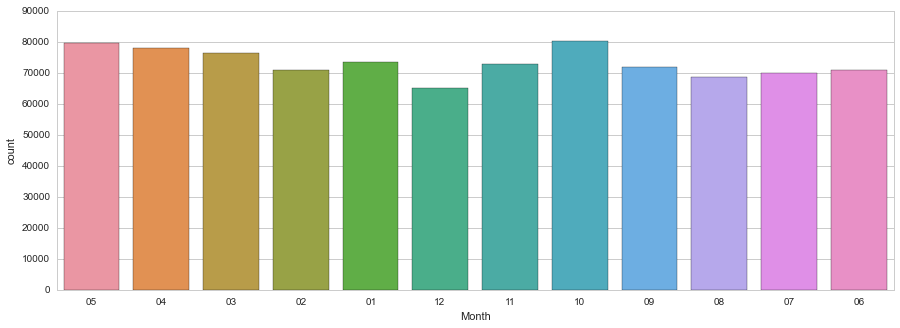

In [54]:
# Plot
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))

sns.countplot(x=crimes_df["Month"], ax=axis1)

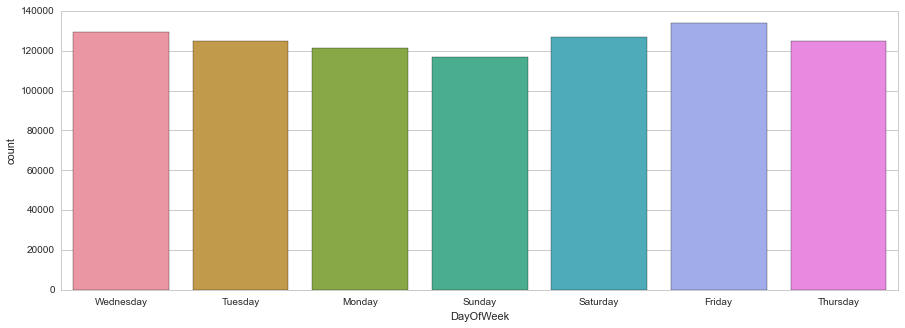

In [55]:
# Plot
# Which DayOfWeek has higher number of crimes
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x=crimes_df["DayOfWeek"], ax=axis1)

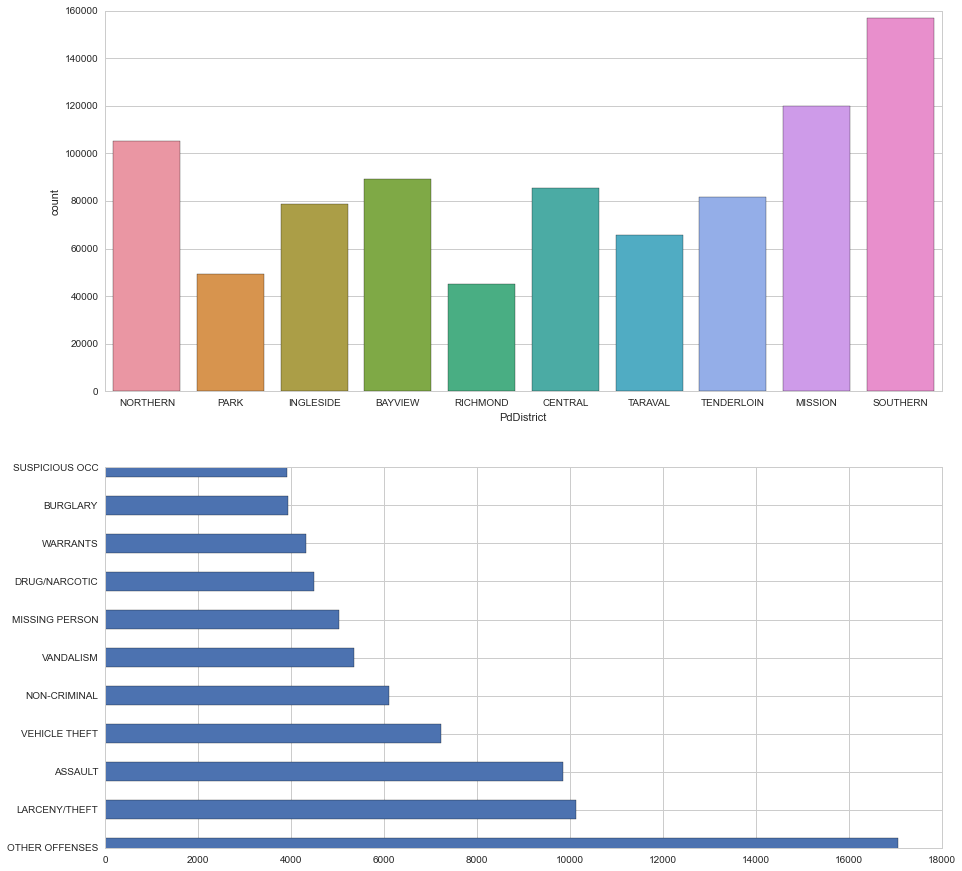

In [56]:
# Plot
# Which PdDistrict has higher number of crimes
fig, (axis1, axis2) = plt.subplots(2,1,figsize=(15,15))
sns.countplot(x=crimes_df["PdDistrict"], ax=axis1)

# most frequent crimes in a PdDistrict
crimes_df["Category"][crimes_df["PdDistrict"] == 'BAYVIEW'].value_counts().plot(kind='barh', ax=axis2, ylim=(0,10))

In [57]:
p = ('Set2', 'Paired', 'colorblind', 'husl',
        'Set1', 'coolwarm', 'RdYlGn', 'spectral')
clr = sns.color_palette(np.random.choice(p), len(crimes_df))

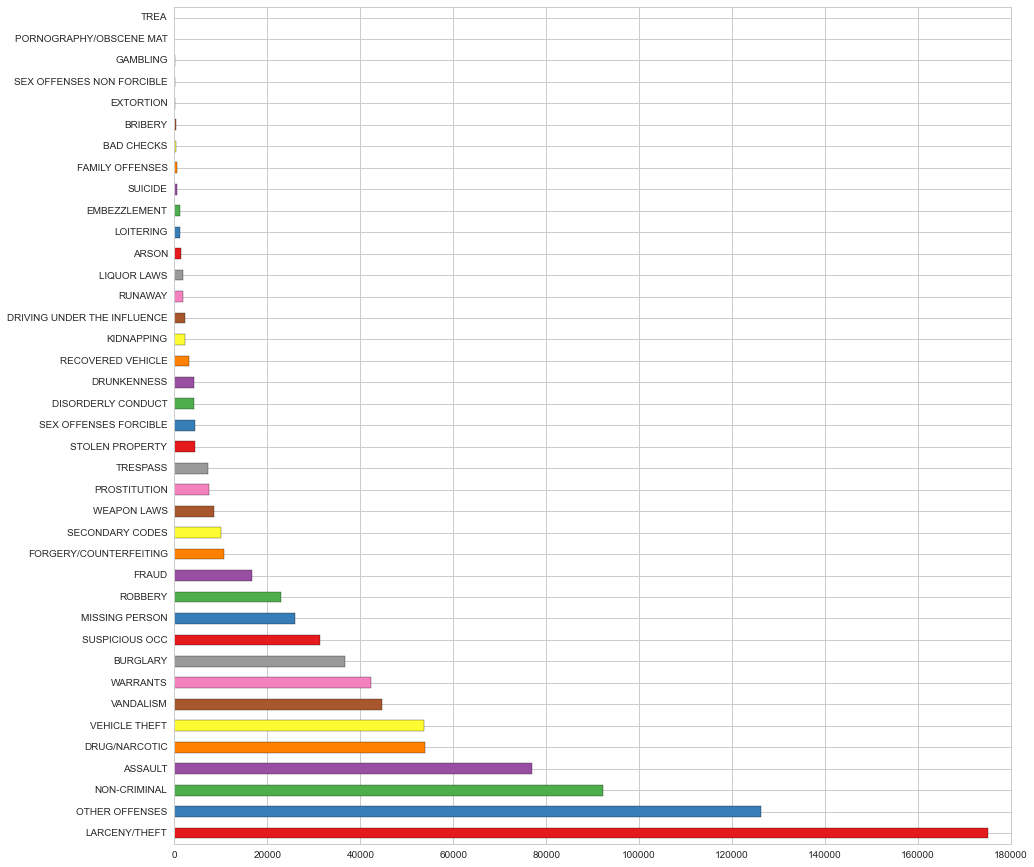

In [58]:
# Category

# Plot
crimes_df["Category"].value_counts().plot(kind='barh', figsize=(15,15), color=clr)



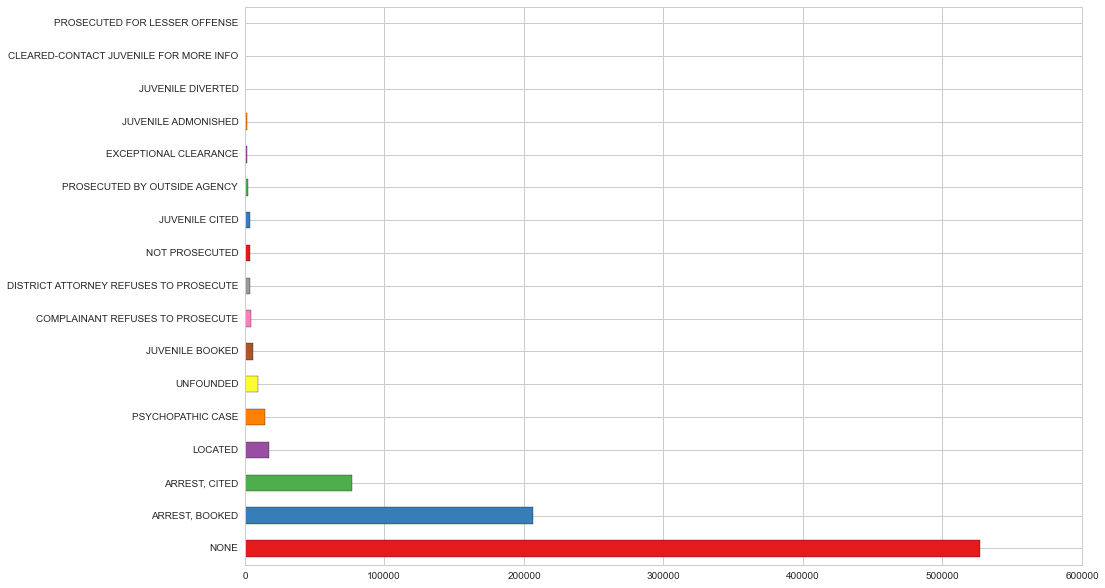

In [59]:
# Plot
crimes_df["Resolution"].value_counts().plot(kind='barh', figsize=(15,10), color=clr)


In [60]:
lbl = preprocessing.LabelEncoder()
lbl.fit(list(crimes_df["DayOfWeek"].values) + list(test_df["DayOfWeek"].values))
crimes_df["DayOfWeek"] = lbl.transform(crimes_df["DayOfWeek"].values)
test_df["DayOfWeek"] = lbl.transform(test_df["DayOfWeek"].values)


In [61]:
lbl.fit(list(crimes_df["PdDistrict"].values) + list(test_df["PdDistrict"].values))
crimes_df["PdDistrict"] = lbl.transform(crimes_df["PdDistrict"].values)
test_df["PdDistrict"] = lbl.transform(test_df["PdDistrict"].values)

In [62]:
ordered_crimes   = crimes_df["Category"].value_counts().index.order()
map_values_dic   = Series(range(0,len(ordered_crimes)), index=ordered_crimes).to_dict()

crimes_df['Category'] = crimes_df['Category'].map(map_values_dic)

In [63]:
crimes_df.head(1)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Time,Hours
0,2015-05-13 23:53:00,37,WARRANT ARREST,6,4,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,05,13,23:53:00,23


In [64]:
test_df.head(1)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,Day,Time,Hours
0,0,2015-05-10 23:59:00,3,0,2000 Block of THOMAS AV,-122.399588,37.735051,2015,05,10,23:59:00,23


In [65]:
#Dropping unneccessary columns
crimes_df.drop(["Dates","Descript","Time","Resolution"],axis=1,inplace=True)
test_df.drop(["Dates","Time"],axis=1,inplace=True)

Due to having a low RAM and Cores I am now able to process the data for prediction. My system hangs everytime I try to do it. :( 